<a href="https://colab.research.google.com/github/Nhlanhla-Mackenzie-30/MIT805Project/blob/main/MIT_805_EXAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install PySpark
!pip install pyspark
#Import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, when, sum as spark_sum, max as spark_max, min as spark_min, to_date, date_format
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import os
from PIL import Image
from collections import defaultdict, Counter

In [ ]:
!kaggle datasets download francescaabulencia/cms-data-2018-to-2020

Dataset URL: https://www.kaggle.com/datasets/francescaabulencia/cms-data-2018-to-2020
License(s): unknown
100% 1.75G/1.76G [00:17<00:00, 116MB/s]
100% 1.76G/1.76G [00:17<00:00, 109MB/s]


In [ ]:
!unzip cms-data-2018-to-2020.zip

Archive:  cms-data-2018-to-2020.zip
  inflating: MUP_DPR_RY21_P04_V10_DY18_NPIBN_0.csv  
  inflating: MUP_DPR_RY21_P04_V10_DY19_NPIBN_1.csv  
  inflating: MUP_DPR_RY22_P04_V10_DY20_NPIBN_0.csv  


Initial Data:
+-----------+---------------------+------------------+------------+--------------------+------------------+-----------------+----------------+--------------------+--------------------+--------+---------------+-------------+------------+---------+---------------+-------------+--------------------+-----------------+------------------+--------------------+--------------+
|Prscrbr_NPI|Prscrbr_Last_Org_Name|Prscrbr_First_Name|Prscrbr_City|Prscrbr_State_Abrvtn|Prscrbr_State_FIPS|     Prscrbr_Type|Prscrbr_Type_Src|           Brnd_Name|           Gnrc_Name|Tot_Clms|Tot_30day_Fills|Tot_Day_Suply|Tot_Drug_Cst|Tot_Benes|GE65_Sprsn_Flag|GE65_Tot_Clms|GE65_Tot_30day_Fills|GE65_Tot_Drug_Cst|GE65_Tot_Day_Suply|GE65_Bene_Sprsn_Flag|GE65_Tot_Benes|
+-----------+---------------------+------------------+------------+--------------------+------------------+-----------------+----------------+--------------------+--------------------+--------+---------------+-------------+------------+--------

<ipython-input-8-a7a2fd851967>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_stats_pd, x="Prscrbr_State_Abrvtn", y="avg_drug_cost", palette="viridis")


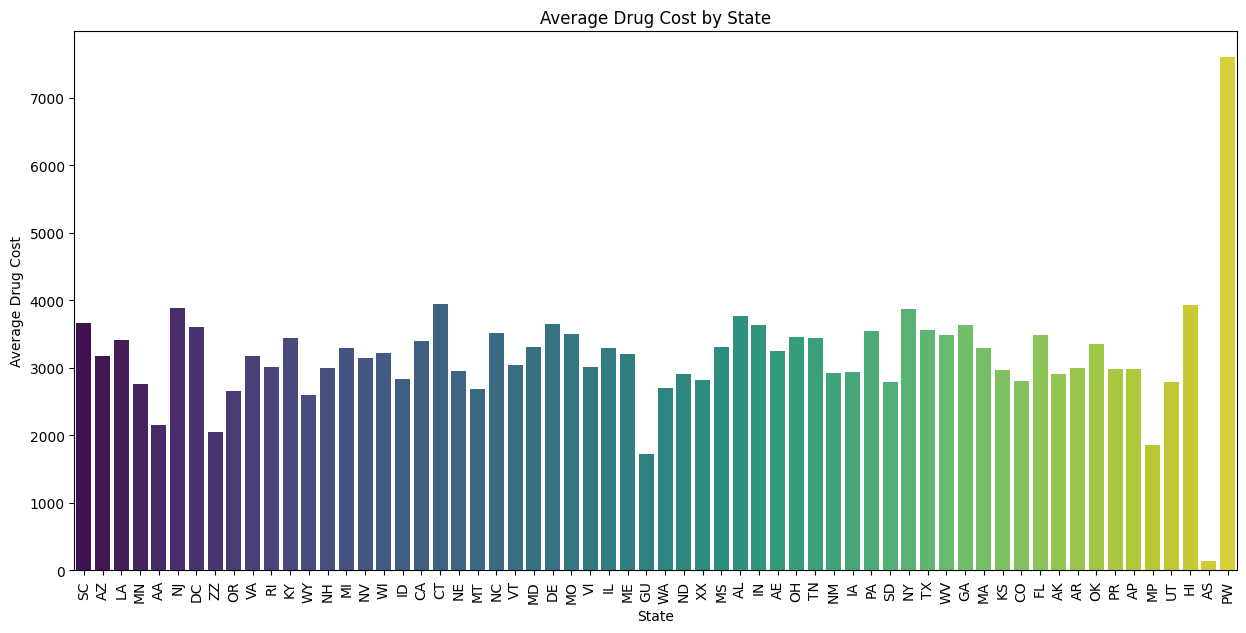

Disease Prediction Accuracy: 0.4
              precision    recall  f1-score   support

           0       0.39      0.47      0.43        95
           1       0.41      0.33      0.37       105

    accuracy                           0.40       200
   macro avg       0.40      0.40      0.40       200
weighted avg       0.40      0.40      0.40       200



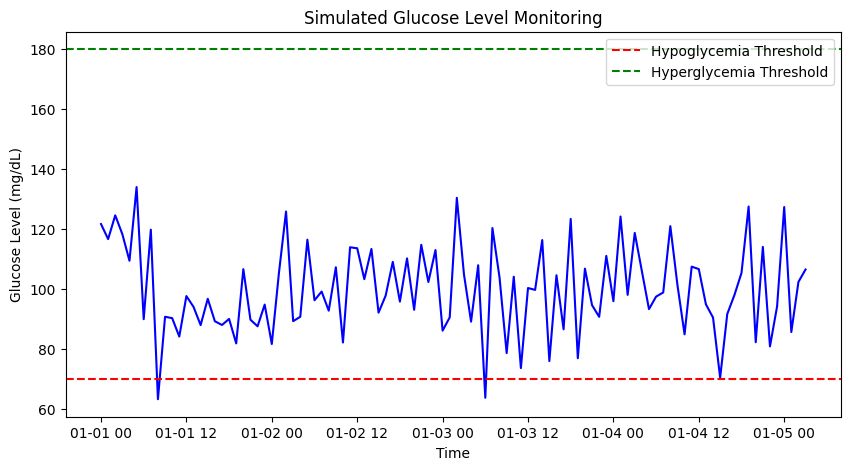

Integrated Data:
   patient_id hospital_name     diagnosis  clinic_visit_count primary_doctor
0           1    Hospital A      Diabetes                   5      Dr. Smith
1           2    Hospital B  Hypertension                   3        Dr. Lee
2           3    Hospital C        Asthma                   4       Dr. Khan
3           4    Hospital A      Diabetes                   2      Dr. Smith
4           5    Hospital B  Hypertension                   1        Dr. Lee
Average Patient Satisfaction Score: 2.90


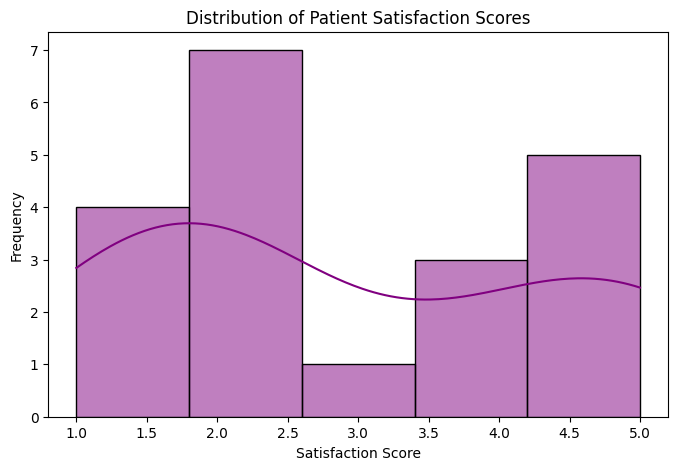

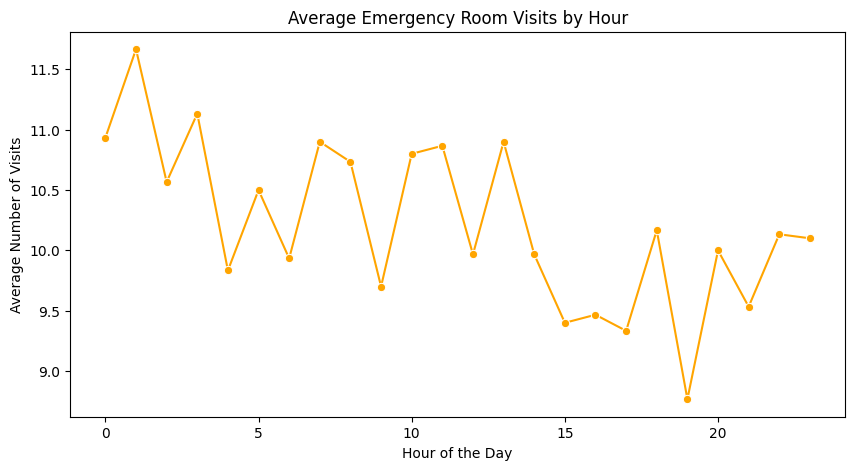

In [ ]:
# Import libraries
!pip install pyspark pandas matplotlib seaborn

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, when, sum as spark_sum, max as spark_max, min as spark_min
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

#Initialize Spark Session
spark = SparkSession.builder \
    .appName("Healthcare Big Data Analysis") \
    .config("spark.executor.memory", "10g") \
    .config("spark.driver.memory", "10g") \
    .getOrCreate()

# Load CSV Files
file_path = ["/content/MUP_DPR_RY21_P04_V10_DY18_NPIBN_0.csv",
             "/content/MUP_DPR_RY22_P04_V10_DY20_NPIBN_0.csv",
             "/content/MUP_DPR_RY22_P04_V10_DY20_NPIBN_0.csv"]

healthcare_df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show initial data
print("Initial Data:")
healthcare_df.show(5)
print("Schema:")
healthcare_df.printSchema()

# Check for Missing Data
missing_data_df = healthcare_df.select([count(when(col(c).isNull(), c)).alias(c) for c in healthcare_df.columns])
print("Missing data in each column:")
missing_data_df.show()

# Clean the data
essential_columns = ["Prscrbr_NPI", "Prscrbr_Last_Org_Name", "Prscrbr_State_Abrvtn", "Tot_Clms", "Tot_Drug_Cst"]

# Drop rows with nulls
cleaned_healthcare_df = healthcare_df.na.drop(subset=essential_columns)

# Remove rows with invalid data
cleaned_healthcare_df = cleaned_healthcare_df.filter(
    (col("Tot_Drug_Cst") > 0) & (col("Tot_Drug_Cst") < 100000)
)

print("Cleaned Data:")
cleaned_healthcare_df.show()

#Exploratory Data Analysis (EDA)
summary_stats = cleaned_healthcare_df.select(
    avg("Tot_Drug_Cst").alias("avg_drug_cost"),
    spark_max("Tot_Drug_Cst").alias("max_drug_cost"),
    spark_min("Tot_Drug_Cst").alias("min_drug_cost"),
    avg("Tot_Clms").alias("avg_claims"),
    spark_max("Tot_Clms").alias("max_claims"),
    spark_min("Tot_Clms").alias("min_claims")
)
print("Summary Statistics:")
summary_stats.show()

state_stats = cleaned_healthcare_df.groupBy("Prscrbr_State_Abrvtn").agg(
    count("Prscrbr_NPI").alias("total_providers"),
    avg("Tot_Drug_Cst").alias("avg_drug_cost"),
    avg("Tot_Clms").alias("avg_claims")
)
print("State-wise Statistics:")
state_stats.show()

# Convert to Pandas for plotting
state_stats_pd = state_stats.toPandas()

plt.figure(figsize=(15, 7))
sns.barplot(data=state_stats_pd, x="Prscrbr_State_Abrvtn", y="avg_drug_cost", palette="viridis")
plt.xticks(rotation=90)
plt.title("Average Drug Cost by State")
plt.xlabel("State")
plt.ylabel("Average Drug Cost")
plt.show()

#Predictive Analytics for Disease Management
np.random.seed(0)
data = pd.DataFrame({
    'age': np.random.randint(20, 80, 1000),
    'bmi': np.random.uniform(18.5, 40, 1000),
    'blood_pressure': np.random.randint(100, 180, 1000),
    'cholesterol_level': np.random.randint(150, 300, 1000),
    'diabetes': np.random.choice([0, 1], 1000)
})

X = data.drop('diabetes', axis=1)
y = data['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print("Disease Prediction Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

#Real-time Health Monitoring
time_series_data = pd.DataFrame({
    'timestamp': pd.date_range(start='2022-01-01', periods=100, freq='H'),
    'glucose_level': np.random.normal(100, 15, 100)
})

plt.figure(figsize=(10, 5))
plt.plot(time_series_data['timestamp'], time_series_data['glucose_level'], color='blue')
plt.title("Simulated Glucose Level Monitoring")
plt.xlabel("Time")
plt.ylabel("Glucose Level (mg/dL)")
plt.axhline(y=70, color='red', linestyle='--', label="Hypoglycemia Threshold")
plt.axhline(y=180, color='green', linestyle='--', label="Hyperglycemia Threshold")
plt.legend()
plt.show()

#Data Integration
hospital_data = pd.DataFrame({
    'patient_id': range(1, 6),
    'hospital_name': ['Hospital A', 'Hospital B', 'Hospital C', 'Hospital A', 'Hospital B'],
    'diagnosis': ['Diabetes', 'Hypertension', 'Asthma', 'Diabetes', 'Hypertension']
})

clinic_data = pd.DataFrame({
    'patient_id': [1, 2, 3, 4, 5],
    'clinic_visit_count': [5, 3, 4, 2, 1],
    'primary_doctor': ['Dr. Smith', 'Dr. Lee', 'Dr. Khan', 'Dr. Smith', 'Dr. Lee']
})

integrated_data = pd.merge(hospital_data, clinic_data, on='patient_id', how='inner')
print("Integrated Data:")
print(integrated_data)

#Patient Engagement through Data Analytics
satisfaction_data = pd.DataFrame({
    'patient_id': range(1, 21),
    'satisfaction_score': np.random.randint(1, 6, 20)
})

satisfaction_avg = satisfaction_data['satisfaction_score'].mean()
print(f"Average Patient Satisfaction Score: {satisfaction_avg:.2f}")

plt.figure(figsize=(8, 5))
sns.histplot(satisfaction_data['satisfaction_score'], bins=5, kde=True, color='purple')
plt.title("Distribution of Patient Satisfaction Scores")
plt.xlabel("Satisfaction Score")
plt.ylabel("Frequency")
plt.show()

# Resource Optimization through Data Analysis
er_data = pd.DataFrame({
    'hour': np.tile(range(24), 30),
    'visits': np.random.poisson(lam=10, size=24*30)
})

hourly_visits = er_data.groupby('hour')['visits'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly_visits, x='hour', y='visits', marker="o", color='orange')
plt.title("Average Emergency Room Visits by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Number of Visits")
plt.show()
